### Binary file creator

In [5]:
import pandas as pd
import struct
import os

# read CSV into Pandas DataFrame
df = pd.read_csv('/home/jovyan/work/Mall_Customers.csv')
df = df.dropna(how='any')
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = df.astype(float)
df = df.drop("CustomerID", axis=1)
#df = df.drop("Gender", axis=1)
print(df.dtypes)
#df = df.sort_values(by=['Gender', 'Age','Annual Income (k$)','Spending Score (1-100)'], ascending=[True, True,True,True])
display(df)

import struct

num_points = len(df)
num_dimensions = len(df.columns)
print(num_points)
# write binary file
with open('/home/jovyan/work/PinkMST/PinkMST/data/data.bin', 'wb') as f:
    # write number of points and dimensions in little-endian format
    f.write(struct.pack('<i', num_points))
    f.write(struct.pack('<i', num_dimensions))

    # write each point to file in binary format
    for _, row in df.iterrows():
        #print("-------------------------")
        for value in row:
            #print(value)
            f.write(struct.pack('<d', value))


Gender                    float64
Age                       float64
Annual Income (k$)        float64
Spending Score (1-100)    float64
dtype: object


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,19.0,15.0,39.0
1,1.0,21.0,15.0,81.0
2,0.0,20.0,16.0,6.0
3,0.0,23.0,16.0,77.0
4,0.0,31.0,17.0,40.0
...,...,...,...,...
195,0.0,35.0,120.0,79.0
196,0.0,45.0,126.0,28.0
197,1.0,32.0,126.0,74.0
198,1.0,32.0,137.0,18.0


200


### Imports

In [3]:
from classes.pink import Pink
from classes.pinkMST import PinkMST, MyEdgeComparable
from classes.point import Point
from classes.edge import Edge
from classes.dataSplitter import DataSplitter
from classes.unionFind import UnionFind

import time
import logging
import math
import os
import sys
import time

from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType, DoubleType, NullType, LongType, StringType

### initializations 

In [4]:
K = 4
numDataSplits = 4
numPoints = 200
numDimensions = 4
dataSetName = "data"
configFile = None

PROJECT_HOME = os.getcwd()


#numSubGraphs is the total number of subgraph inclding the combinations of bipartite graphs
numSubGraphs = int(numDataSplits * (numDataSplits - 1) / 2 + numDataSplits)

EXPERIMENT_HOME = PROJECT_HOME + "/data/" +dataSetName + "_d" + str(numDimensions) + "_s" + str(numDataSplits)
os.makedirs(EXPERIMENT_HOME, exist_ok=True)

# number of subgraphs
idPartitionFilesLoc = EXPERIMENT_HOME + "/subgraphIds"
# number of dataPartitions
dataPartitionFilesLoc = EXPERIMENT_HOME + "/dataPartitions"

binaryFileName = PROJECT_HOME + "/data/" + dataSetName + ".bin"


print("PinkConfig: dataSet=%s numPoints=%d numDimensions=%d numDataSplits=%d K=%d configFile=%s"
        % (dataSetName, numPoints, numDimensions, numDataSplits, K, configFile))
print("working directory : "+ PROJECT_HOME)
print("Data directory : "+ PROJECT_HOME)
print("location of partition ids 'subgraph ids' files : "+idPartitionFilesLoc)
print("location of subgraphs data :"+dataPartitionFilesLoc)
print("binaryFileName : "+binaryFileName)

PinkConfig: dataSet=data numPoints=200 numDimensions=4 numDataSplits=4 K=4 configFile=None
working directory : /home/jovyan/work/PinkMST/PinkMST
Data directory : /home/jovyan/work/PinkMST/PinkMST
location of partition ids 'subgraph ids' files : /home/jovyan/work/PinkMST/PinkMST/data/data_d4_s4/subgraphIds
location of subgraphs data :/home/jovyan/work/PinkMST/PinkMST/data/data_d4_s4/dataPartitions
binaryFileName : /home/jovyan/work/PinkMST/PinkMST/data/data.bin


## PinkMST

### Data preparation

In [5]:
start_time_in_milliseconds = int(time.time() * 1000)
# creation of DataSplitter instance
splitter = DataSplitter(binaryFileName, numDataSplits, dataPartitionFilesLoc, configFile)

#creation of numSubgraphs partitions files, each partition file refers to a subgraph
splitter.create_partition_files(idPartitionFilesLoc, numSubGraphs)

#creation of numDataSplits parquet files, each parquet file will contain a subset of the whole graph data
splitter.write_parquet_files(numPoints, numDimensions)

#getting spark context and spark instance
sc = splitter.get_spark_context()
spark = SparkSession.builder.getOrCreate()

================calling create_partition_files from DataSplitter==================
numPartions : 10
create idSubgraph files: /home/jovyan/work/PinkMST/PinkMST/data/data_d4_s4/subgraphIds
idPartitions succefully written
================ create_partition_files completed ==================
================calling write_parquet_files from DataSplitter==================
point_size_in_bytes : 32
data dimensions: 200,4
=====:  0: [1.0, 19.0, 15.0, 39.0]
=====:  1: [1.0, 21.0, 15.0, 81.0]
=====:  2: [0.0, 20.0, 16.0, 6.0]
=====:  3: [0.0, 23.0, 16.0, 77.0]
=====:  4: [0.0, 31.0, 17.0, 40.0]
=====:  5: [0.0, 22.0, 17.0, 76.0]
parquet files succefully written
================ write_parquet_files completed ==================


### reading the data

In [59]:
# create an rdd that have the number of partitions :: each line has the id of each partition with a total of num_subgraphs id
partitionRDD = sc.textFile(idPartitionFilesLoc, numSubGraphs)
partitionRDD.collect()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [60]:
#extract the files names to iterate through them
#in this step the original code sent the graph id to GetPartitionFunction which called get_subgraph_pair to extract respective graph data points. get_subgraph_pair called the get_right_id, get_left_id and the open_files to extract the data points, however, opening the files required creating a spark context in the worker nodes which returned an error.
#Now, the process is as follows : we call getFilesNmaes which returns (partition_id, left_file_name, right_file_name) that represents the two files containing the graph data
filesNamesRdd = partitionRDD.map(lambda x : Pink.getFilesNames(x, numDataSplits, dataPartitionFilesLoc))
filesNamesRddArray = filesNamesRdd.collect()
filesNamesRddArray

[(0,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00000',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00001'),
 (1,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00000',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00002'),
 (2,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00001',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00002'),
 (3,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00000',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00003'),
 (4,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00001',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00003'),
 (5,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00002',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00003'),
 (6,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00000',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00000'),
 (7,
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-00001',
  '/home/jovyan/work/data_d4_s4/dataPartitions/part-0

In [61]:
#for each graph (partition_id, left_file_name, right_file_name), getPointsList will return (partitionId, [leftPointsData], [rightPointsData] )
pointsList = Pink.getPointsList(filesNamesRddArray, spark)
graphsPairRdd = sc.parallelize(pointsList)
print("number of partitions : "+str(graphsPairRdd.count()))
print("number of points in each partition"+str(graphsPairRdd.map(lambda x : (x[0], len(x[1])+len(x[2]))).collect()))

number of partitions : 10
number of points in each partition[(0, 101), (1, 100), (2, 101), (3, 99), (4, 100), (5, 99), (6, 50), (7, 51), (8, 50), (9, 49)]


In [108]:
#we will create Points object for each point in leftPointsData, rightPointsData arrays. the function returns : (partitionId, [leftPoints], [rightPoints] )
graphsPairPointsRdd = graphsPairRdd.map(lambda x : Pink.toPoints(x))
graphsPairPointsRdd.take(8)

[(0,
  [44: [0.0, 49.0, 39.0, 28.0],
   37: [0.0, 30.0, 34.0, 73.0],
   26: [0.0, 45.0, 28.0, 32.0],
   0: [1.0, 19.0, 15.0, 39.0],
   27: [1.0, 35.0, 28.0, 61.0],
   36: [0.0, 42.0, 34.0, 17.0],
   5: [0.0, 22.0, 17.0, 76.0],
   29: [0.0, 23.0, 29.0, 87.0],
   7: [0.0, 23.0, 18.0, 94.0],
   23: [1.0, 31.0, 25.0, 73.0],
   32: [1.0, 53.0, 33.0, 4.0],
   10: [1.0, 67.0, 19.0, 14.0],
   66: [0.0, 43.0, 48.0, 50.0],
   91: [1.0, 18.0, 59.0, 41.0],
   99: [1.0, 20.0, 61.0, 49.0],
   53: [1.0, 59.0, 43.0, 60.0],
   94: [0.0, 32.0, 60.0, 42.0],
   74: [1.0, 59.0, 54.0, 47.0],
   51: [1.0, 33.0, 42.0, 60.0],
   60: [1.0, 70.0, 46.0, 56.0],
   59: [1.0, 53.0, 46.0, 46.0],
   57: [1.0, 69.0, 44.0, 46.0],
   62: [0.0, 67.0, 47.0, 52.0],
   75: [1.0, 26.0, 54.0, 54.0],
   109: [1.0, 66.0, 63.0, 48.0],
   127: [1.0, 40.0, 71.0, 95.0],
   121: [0.0, 38.0, 67.0, 40.0],
   140: [0.0, 57.0, 75.0, 5.0],
   118: [0.0, 51.0, 67.0, 43.0],
   148: [0.0, 34.0, 78.0, 22.0],
   138: [1.0, 19.0, 74.0, 10.0],
 

### calculating the MST of each subgraph

In [63]:
#for each partitionId"subGraph", PinkMST will return the edges that form the MST of that subgraph in the format (partition_id, edge). edgeListRDD will contain the list of edges that form the MST in the following format (partition_id, edge).
edgesListRDD = graphsPairPointsRdd.flatMap(lambda x: PinkMST( (x[1],x[2]), x[0]).getEdgeList())

In [64]:
edgesListRDD.take(5)

[(0, <edge.Edge at 0x7f40704e7a90>),
 (0, <edge.Edge at 0x7f40704e7940>),
 (0, <edge.Edge at 0x7f40704e7880>),
 (0, <edge.Edge at 0x7f40704e7820>),
 (0, <edge.Edge at 0x7f40704e77c0>)]

### merging the MSTs

In [65]:
#the merging step
#combineByKey will combine the rdd of (partition_id, edge) by partition_id. mstToBeMerged will contain (partition_id, [list_of_edges])
kruskal_reducer = Pink.KruskalReducer(numPoints)
mstToBeMerged = edgesListRDD.combineByKey(Pink.CreateCombiner(), Pink.Merger(), kruskal_reducer)


In [66]:
print("list of edges in each partition : ")
mstToBeMerged.map(lambda x: (x[0], x[1][:3])).take(3)

list of edges in each partition : 


[(0,
   <edge.Edge at 0x7f40704e61d0>]),
 (8,
   <edge.Edge at 0x7f401e34f340>]),
 (1,
   <edge.Edge at 0x7f401e34caf0>])]

In [67]:
print("number of edges in each partition : ")
mstToBeMerged.map(lambda x: (x[0], len(x[1]))).collect()

number of edges in each partition : 


[(0, 100),
 (8, 49),
 (1, 99),
 (9, 48),
 (2, 101),
 (3, 99),
 (4, 100),
 (5, 99),
 (6, 49),
 (7, 50)]

In [68]:
#KruskalReducer will call SetPartitionIdFunction which change the partitions_id of the components of mstToBeMerged in a way that groups each K partition into the same partition number, so that the merging of the K partitions"MSTs" can be done using the kruskal_reducer class
#this step will be repeated until we have only one partition_id left
numSubGraphs = int(numDataSplits * (numDataSplits - 1) / 2 + numDataSplits)
mstToBeMergedResult = None
kruskal_reducer = Pink.KruskalReducer(numPoints)
while numSubGraphs > 1:
    # numSubGraphs is the number of subgraphs that will be generated based on the number of partitions (numSubGraphs) and the partition size (K)
    numSubGraphs = (numSubGraphs + (K - 1)) // K
    mstToBeMergedResult = mstToBeMerged.map(Pink.SetPartitionIdFunction(K)).reduceByKey(kruskal_reducer.call, numPartitions=numSubGraphs)
    mstToBeMerged = mstToBeMergedResult

In [71]:
print("list of edges in each partition : ")
mstToBeMerged.map(lambda x: (x[0], x[1][:3])).collect()

list of edges in each partition : 


[(0,
   <edge.Edge at 0x7f401e449780>])]

In [72]:
print("number of edges in each partition : ")
mstToBeMerged.map(lambda x: (x[0], len(x[1]))).collect()

number of edges in each partition : 


[(0, 199)]

# MST result check

In [73]:
import networkx as nx

def compare_graphs(graph1, graph2):
    # Step 1: Check number of nodes
    if graph1.number_of_nodes() != graph2.number_of_nodes():
        return False

    # Step 2: Check number of edges
    if graph1.number_of_edges() != graph2.number_of_edges():
        return False

    # Step 3: Compare edges (ignoring node IDs and edge attributes)
    sorted_edges1 = sorted(graph1.edges())
    sorted_edges2 = sorted(graph2.edges())
    
    #if sorted_edges1 != sorted_edges2:
       # return False
    total_PM_weight = sum(graph1.edges[edge]['weight'] for edge in graph1.edges)
    total_LM_weight = sum(graph2.edges[edge]['weight'] for edge in graph2.edges)
    print("Total Parallel MST Weight:", total_PM_weight)
    print("Total Local MST Weight:", total_LM_weight)
    if total_PM_weight != total_LM_weight:
        return False
    return True


In [74]:
graph_data = mstToBeMerged.flatMap(lambda x: x[1]).map(lambda x : (x.get_left(), x.get_right(), x.get_weight()))
paralled_MST = nx.Graph()
paralled_MST.add_weighted_edges_from(graph_data.collect())

In [87]:
import pandas as pd
df = pd.read_csv('/home/jovyan/work/Mall_Customers.csv')
df = df.dropna(how='any')
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = df.astype(float)
df = df.drop("CustomerID", axis=1)
#df = df.drop("Gender", axis=1)
#df = df.sort_values(by=['Gender', 'Age','Annual Income (k$)','Spending Score (1-100)'], ascending=[True, True,True,True])
points = []
for _, row in df.iterrows():
    ids = _
    coords = [row['Gender'],row['Age'],row['Annual Income (k$)'],row['Spending Score (1-100)']]
    #print(str(ids)+"----------"+str(coords))
    points.append((ids, coords))

In [88]:
complete_graph = nx.Graph()
for i in range(len(points)):
    for j in range(i + 1, len(points)):
        distance = sum((a - b) ** 2 for a, b in zip(points[i][1], points[j][1])) ** 0.5
        complete_graph.add_edge(points[i][0], points[j][0], weight=distance)

local_MST = nx.minimum_spanning_tree(complete_graph)

In [89]:
print(compare_graphs(paralled_MST, local_MST))  # Output: True

Total Parallel MST Weight: 1388.7759271704
Total Local MST Weight: 1388.7759271704
True


# plotting the dendrogram

In [90]:
import networkx as nx
import numpy as np
from scipy.sparse import lil_matrix
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
graph_data = mstToBeMerged.flatMap(lambda x: x[1]).map(lambda x : (x.get_left(), x.get_right(), x.get_weight()))

# Create the NetworkX graph after RDD transformations
MST = nx.Graph()
MST.add_weighted_edges_from(graph_data.collect())
n = len(MST.nodes)

/tmp/ipykernel_851/2560282488.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dense_matrix, method='average')


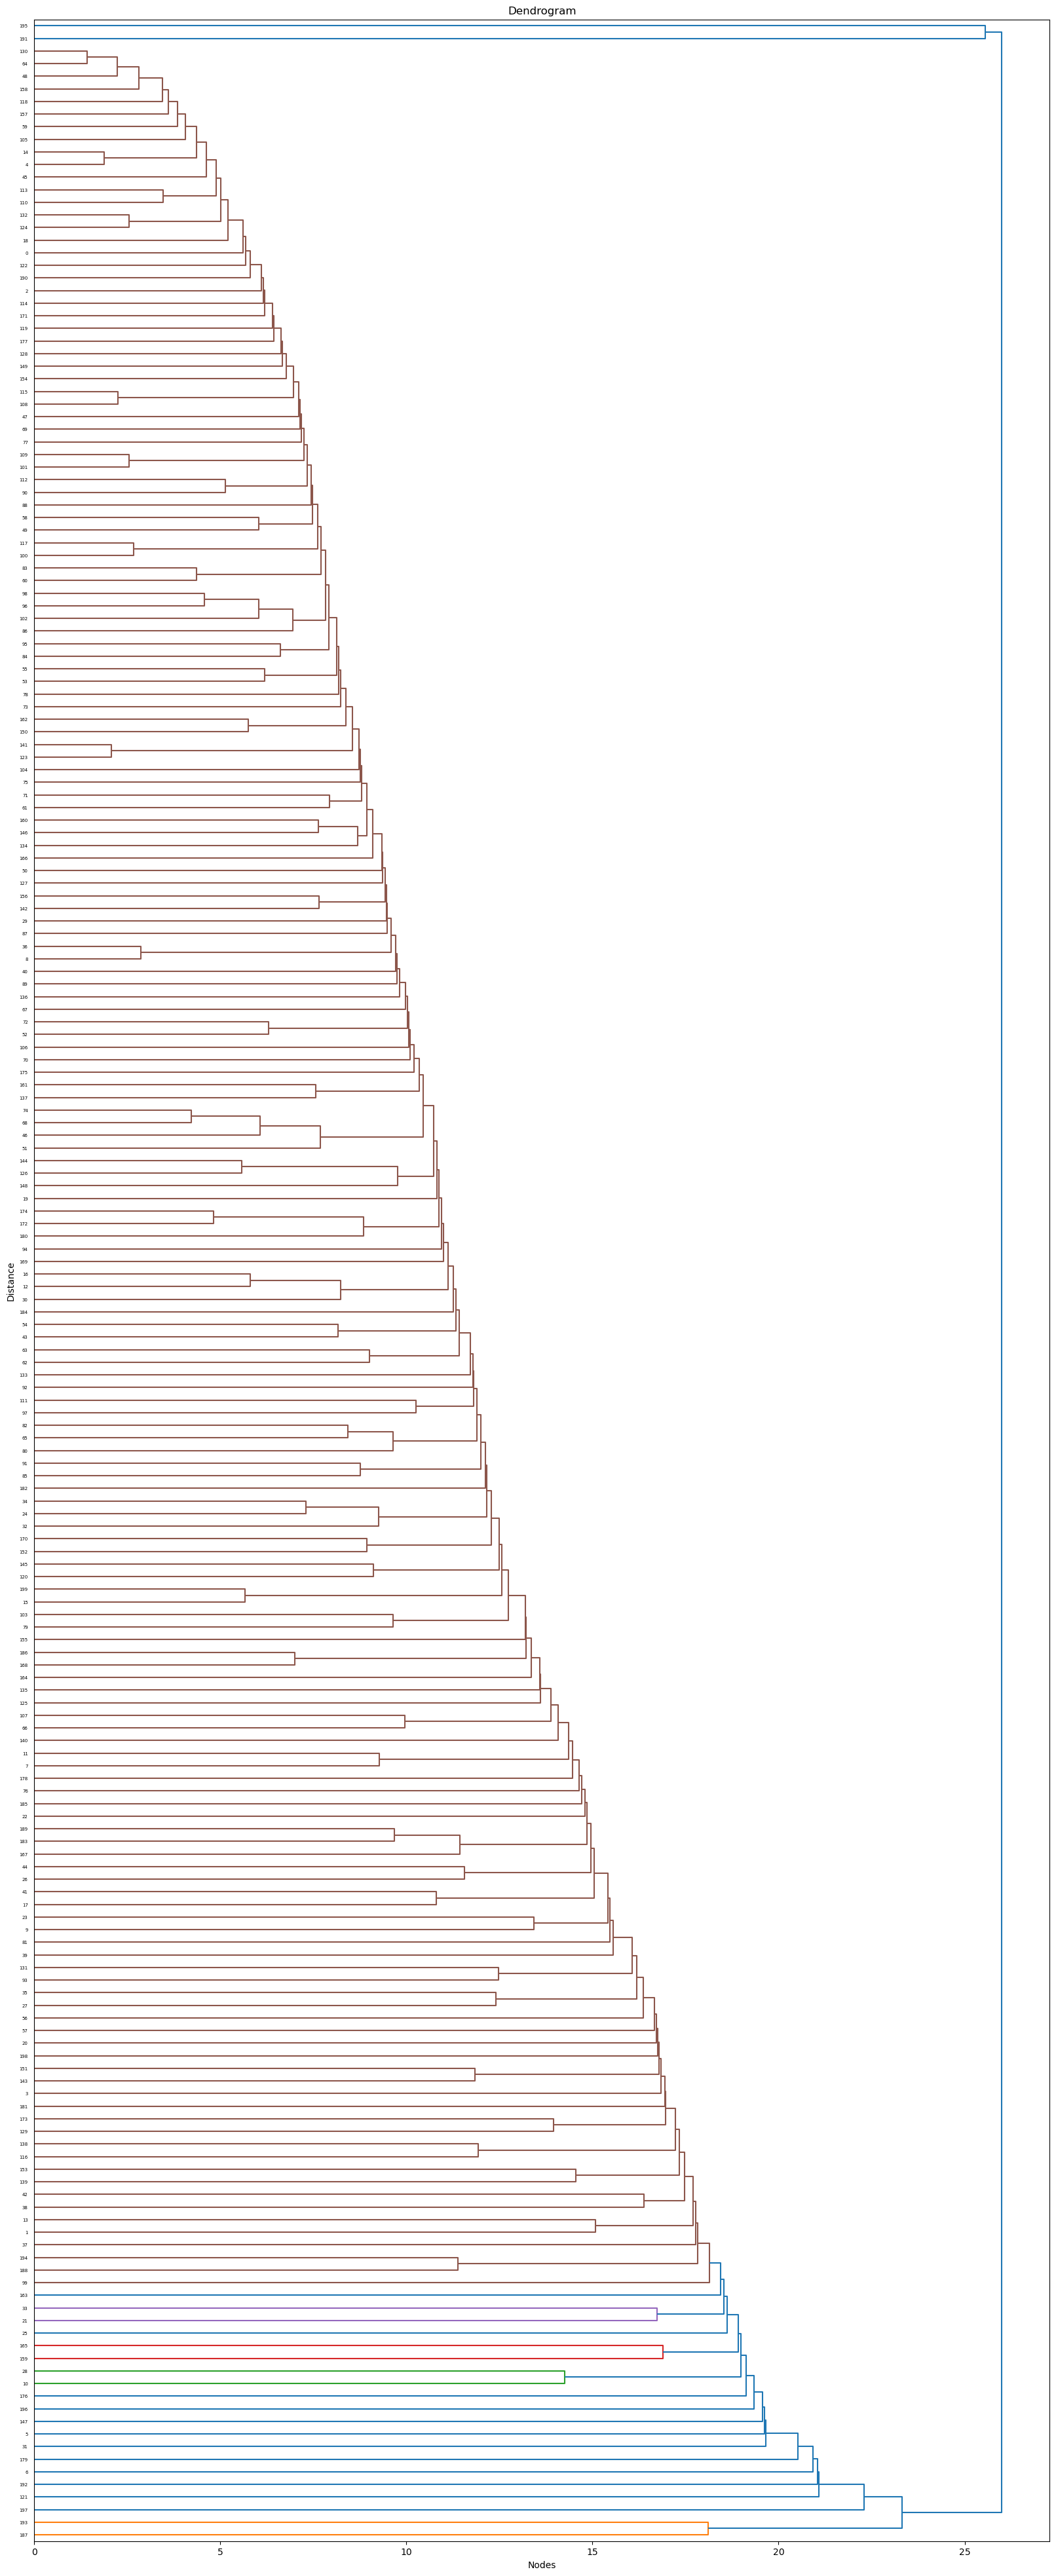

In [91]:
dist_matrix = lil_matrix((n, n))
for u, v, d in MST.edges(data=True):
    dist_matrix[u-1, v-1] = d['weight']
    dist_matrix[v-1, u-1] = d['weight']
# Convert the sparse matrix to a dense matrix
dense_matrix = dist_matrix.toarray()

# Perform clustering on the distance matrix
#clustering = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=8).fit(dense_matrix)
#labels = clustering.labels_

# Calculate the linkage matrix for dendrogram
linkage_matrix = linkage(dense_matrix, method='average')

# Plot the dendrogram
fig = plt.figure(figsize=(20, 50))  # Adjust the width and height as desired
dendrogram_data = dendrogram(linkage_matrix,leaf_rotation=0, orientation = 'right') #labels=labels_
plt.title('Dendrogram')
plt.xlabel('Nodes')
plt.ylabel('Distance')
plt.show()

### plotting the localy MST dendrogramm

/tmp/ipykernel_851/1942705990.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dense_matrix, method='average')


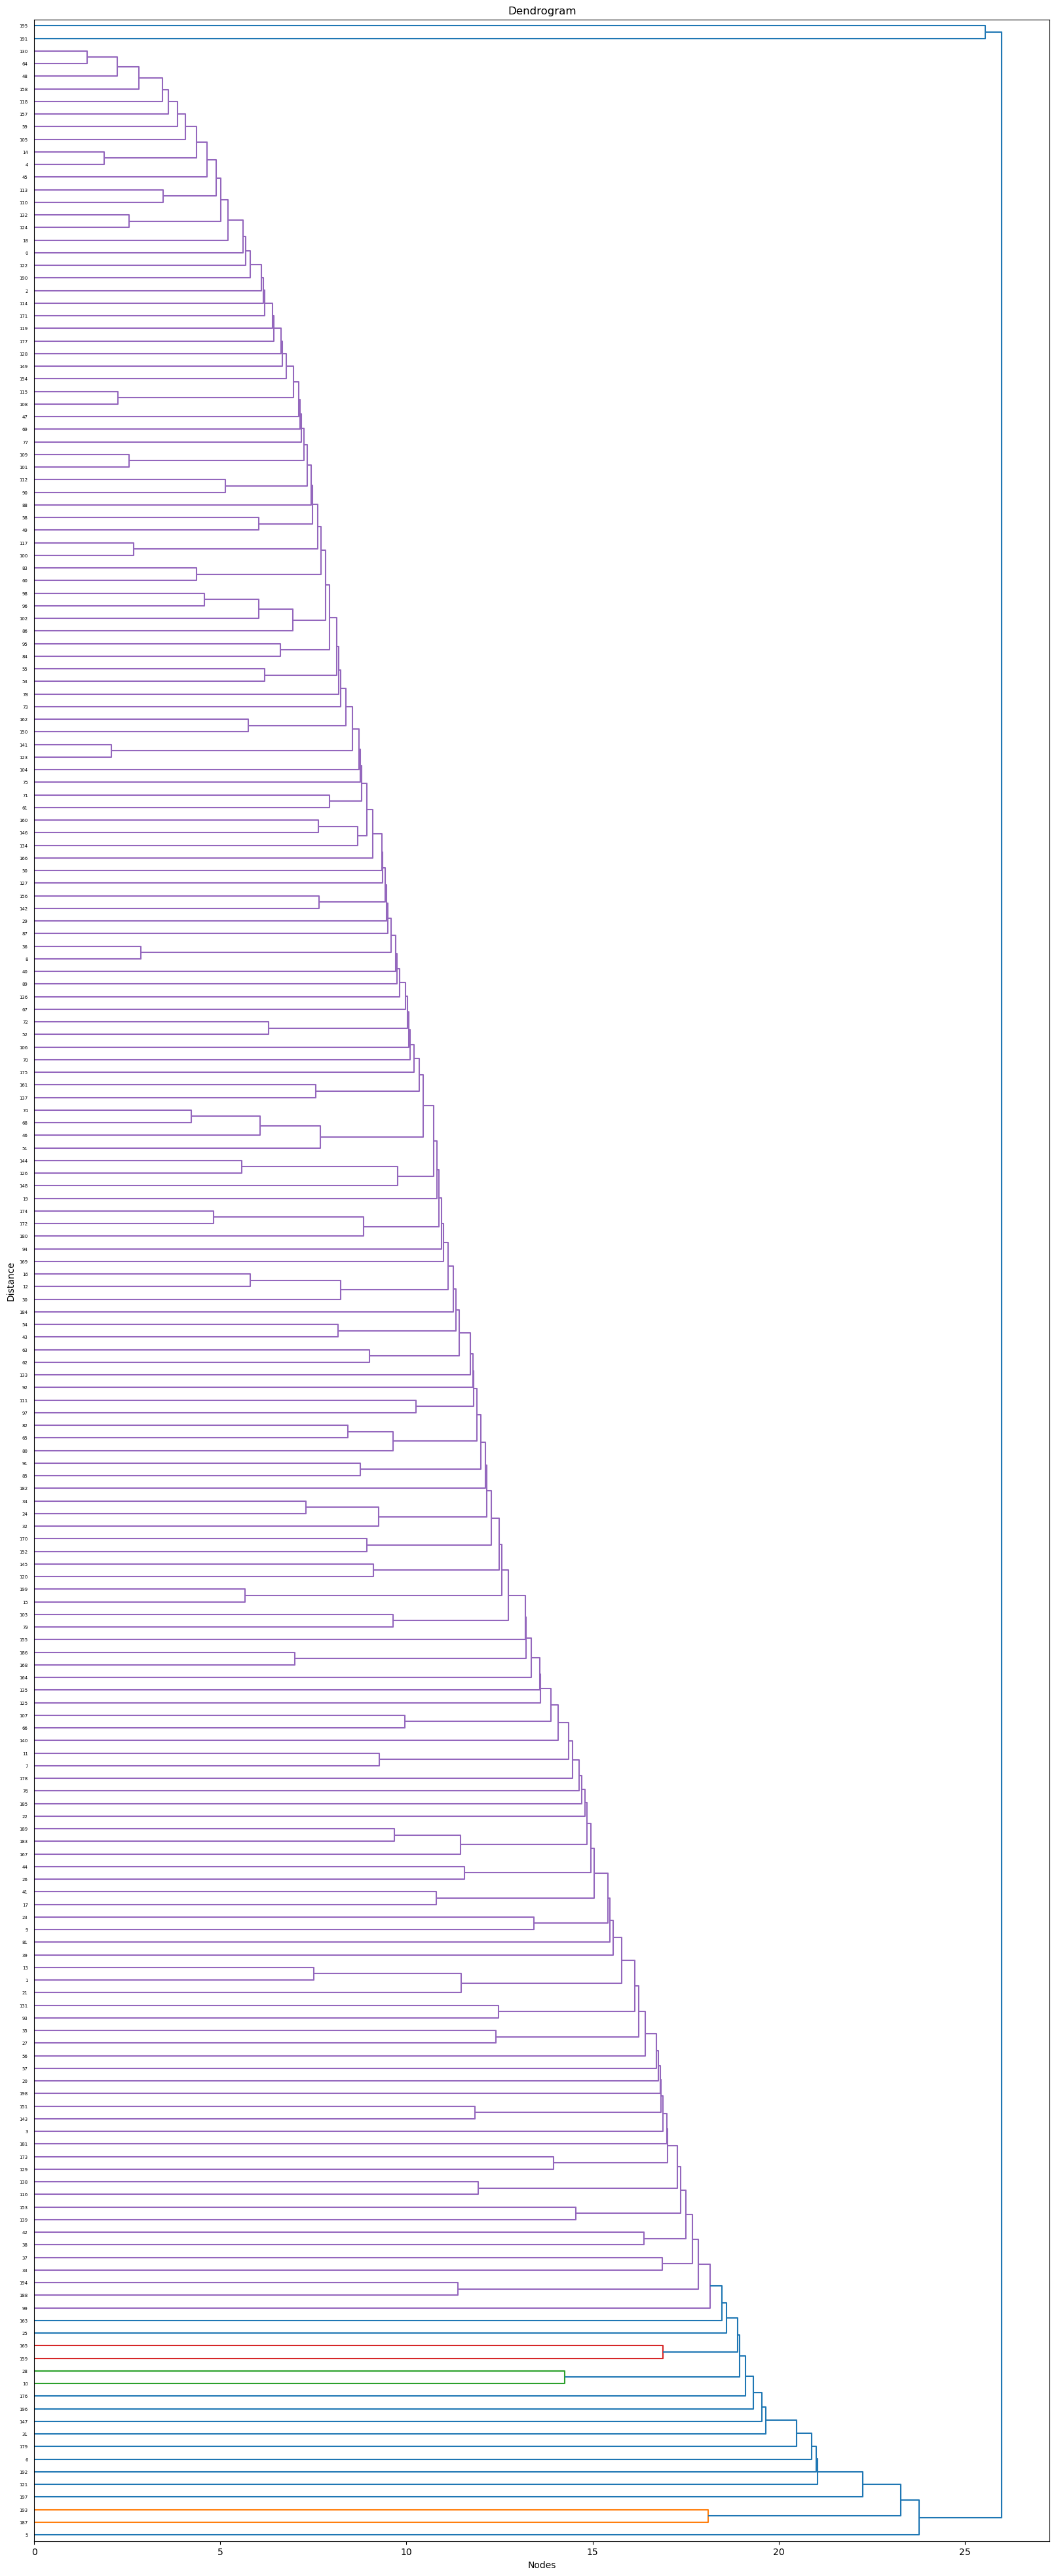

In [92]:
n = len(local_MST.nodes)
dist_matrix = lil_matrix((n, n))
for u, v, d in local_MST.edges(data=True):
    dist_matrix[u-1, v-1] = d['weight']
    dist_matrix[v-1, u-1] = d['weight']
# Convert the sparse matrix to a dense matrix
dense_matrix = dist_matrix.toarray()

# Perform clustering on the distance matrix
#clustering = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=8).fit(dense_matrix)
#labels = clustering.labels_

# Calculate the linkage matrix for dendrogram
linkage_matrix = linkage(dense_matrix, method='average')

# Plot the dendrogram
fig = plt.figure(figsize=(20, 50))  # Adjust the width and height as desired
dendrogram_data = dendrogram(linkage_matrix, orientation='right') #labels=labels_
plt.title('Dendrogram')
plt.xlabel('Nodes')
plt.ylabel('Distance')
plt.show()

# Accuracy

In [98]:
#clustering = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=8).fit(dense_matrix)
#labels = clustering.labels_

In [99]:
#max(labels)

In [100]:
#dense_matrix

In [101]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Create an instance of AgglomerativeClustering and fit it to the distance matrix
clustering = AgglomerativeClustering(n_clusters=3, linkage='single', distance_threshold=None).fit(dense_matrix)
labels = clustering.labels_
# Calculate the silhouette score
silhouette_avg = silhouette_score(dense_matrix, labels)
print("The silhouette score is:", silhouette_avg)

The silhouette score is: 0.44246732326609184


In [102]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 0])

# trying agglomerative clustering from scikit learn

In [103]:
import pandas as pd
df = pd.read_csv('/home/jovyan/work/Mall_Customers.csv')
df = df.dropna(how='any')
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = df.astype(float)
df = df.drop("CustomerID", axis=1)
#df = df.sort_values(by=['Gender', 'Age','Annual Income (k$)','Spending Score (1-100)'], ascending=[True, True,True,True])
points = []
for _, row in df.iterrows():
    ids = _
    coords = [row['Gender'],row['Age'],row['Annual Income (k$)'],row['Spending Score (1-100)']]
    #print(str(ids)+"----------"+str(coords))
    points.append((coords))

In [104]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='single', distance_threshold=None)  # Set the desired number of clusters
labels = agglomerative.fit_predict(points)

In [105]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 0])

In [106]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(points, labels)
print("The silhouette score is:", silhouette_avg)

The silhouette score is: 0.30489109365175143


In [107]:
"""import seaborn as sns
agglom = AgglomerativeClustering(n_clusters=5, linkage='average').fit(points)
points[4] = agglom.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(points['0'], points['1'], hue=points[4], 
                palette=sns.color_palette('hls', 5))
plt.title('Agglomerative with 5 Clusters')
plt.show()"""

"import seaborn as sns\nagglom = AgglomerativeClustering(n_clusters=5, linkage='average').fit(points)\npoints[4] = agglom.labels_\nplt.figure(figsize=(12, 8))\nsns.scatterplot(points['0'], points['1'], hue=points[4], \n                palette=sns.color_palette('hls', 5))\nplt.title('Agglomerative with 5 Clusters')\nplt.show()"

In [1]:
import os

current_directory = os.getcwd()
print(current_directory)


/home/jovyan/work/PinkMST/PinkMST
